# Analyse Badlands surface processes model output

[Badlands](https://github.com/badlands-model/Badlands-doc) produces [Hdf5](https://www.hdfgroup.org/HDF5/) models that we will load, read and process with IPython.

To perform our data analyse we first need to import a series of library s we did with **Basemap** in the first Lab. We will need 
- the **h5py** library to work with the Hdf5 files,
- the usual numeric and plotting python libraries **numpy** & matplotlib.

Badlands computes the surface evolution on an irregular grid and to render the cross-section in this notebook we will forst interpolate the stratigraphic layers from the irregular grid on a regular mesh. To do this we will need the interpolation function from matplotlib **ml** library called.

In [19]:
import h5py
import numpy as np
import matplotlib.mlab as ml
import matplotlib.pyplot as plt

%matplotlib inline

# Hdf5 reading function

The outputs from Badlands contain more than 10 parameters. For our LAB we will only require:
- the position of the irregular points and 
- the thicknesses of each sedimentary layers recorded on each of these points.

Badlands could be ran on several processors to increase its performance. Here we have used 2 processors. Each processor is working on a different region of the grid and the output for each processors are given in a different file. When extracting the data from the files we have to merge these data together. 

In [20]:
def read_h5file(folder,step):
    
    for i in range(0, 2):
        # Load the Hdf5 file
        df = h5py.File('%s/SurfaceSPM.%s.p%s.h5'%(folder, step, i), 'r')
        # Extract the point coordinates
        vertices = np.array((df['/vertices']))
        # Extract the node IDs
        nID = np.array((df['/nID']))
        # Extract the sedimentary layer thicknesses
        layH = np.array((df['/layth']))
    
        # Combine values from the 2 processors in a unique array using the append command
        if i == 0:
            x, y, z = np.hsplit(vertices, 3)
            gID = nID
            glayH = layH
        else:
            gID = np.append(gID, nID)
            glayH = np.append(glayH, layH)
            x = np.append(x, vertices[:,0])
            y = np.append(y, vertices[:,1])
            z = np.append(z, vertices[:,2])
    # Number of stratigraphic horizons recorded in tge output
    nlay = int(step)+1    
    layArray = glayH.reshape((len(x),nlay))
    # Check if there are values existing on both processors
    # and delete any duplicates
    filterID, indices = np.unique(gID, return_index = True)
    merged = np.column_stack((x, y, z))
    topo = merged[indices, :]
    x = topo[:,0]
    y = topo[:,1]
    z = topo[:,2]
    layTH = layArray[indices, 1:]
    
    return x, y, z, layTH

Apply the reading function to the first model 

In [21]:
x, y, z, layTH = read_h5file('/home/tristan/SPM/SedSec/data/init/outputs','0500')

# Interpolate the data from the irregular mesh to a regular one

To create out regular mesh we need to:
- define the resolution `res`, 
- compute the number of points along the X & Y axis (`nx, ny`), 
- create the points coordinate for each axes (`linspace`).

In [23]:
# resolution
res = 100. 

# number of points along X-axis
nx = int((x.max() - x.min())/res+1)
# number of points along Y-axis
ny = int((y.max() - y.min())/res+1)

# Define linearly spaced data along each axis
xi = np.linspace(x.min(), x.max(), nx)
yi = np.linspace(y.min(), y.max(), ny)

# Create the regular mesh
xi, yi = np.meshgrid(xi, yi)

Then we perform a nearest neighbours (`nn`) interpolation using the `griddata` function. First for the elevation values (`z`)

In [24]:
zi = ml.griddata(x,y,z,xi,yi,interp='nn')  

For the thickness of the stratigraphic layers, we need to perform the interpolation on individual layers:

** This step could take several minutes as there are 500 layers to interpolate on the entire mesh.**

In [25]:
# Declare a zero array to store stratigraphic layers thicknesses
strati = np.zeros((zi.shape[0],zi.shape[1],layTH.shape[1]))

# Loop from the sedimentary layer number and perform interpolation
for i in range(layTH.shape[1]):
    stratal =  ml.griddata(x,y,layTH[:,i],xi,yi,interp='nn') 
    # Store the result in array strati
    strati[:,:,i] = stratal    

# Compute sedimentary layers elevations

To visualise the sedimentary layers in cross-sections we need to derive each layer elevations from their thicknesses. To do that we start from the surface and iterate successively over the layers by adding incrementally each layer thickness.

In [28]:
# Declare a zero array to store stratigraphic layers elevations 
stratiElev = np.zeros((zi.shape[0],zi.shape[1],layTH.shape[1]))

# Loop from the sedimentary layer number and convert stratal thickness to elevation
stratiElev[:,:,layTH.shape[1]-1] = zi[:,:]
for i in range(layTH.shape[1]-2,-1,-1):
    stratiElev[:,:,i] = stratiElev[:,:,i+1] - strati[:,:,i+1]

# Plot sedimentary layers in cross section

The simulated region is a 24 by 24 kilometer squared area. We will make a cross-section along the X-axis passing through the middle of the Y-axis.

For this we set the following parameters:
- coordinates of the Y-axis position `pty`,
- index of the points on the Y-axis for this coordinate `yID`,
- X-axis cross-section line coordinates.

In addition, we define several parameters for the plot such as:
- the extent of the graph, 
- the base of the model and
- the sea-level position at the end of the simulation (**it will vary for each model: look at the graph showing sea-level variations for the models in the LAB notes**)

In [30]:
# Y value for the cross-section
pty = 12000.
# Find the ID of the node along the Y-axis that has the chosen coordinate
yID = int((pty - yi.min())/res)

# Define the cross-section line
xi00 = np.linspace(x.min(), x.max(), nx)

# Additional parameters used to define plot extent
minX = x.min()
maxX = x.max()
minZ = zi[yID,:].min()
maxZ = zi[yID,:].max()

# The base of the model is fixed to -600 m
base = np.zeros((xi00.shape[0]))
base.fill(-600.)

# Define sea-level elevation
sl = np.zeros((xi00.shape[0]))
sl.fill(0.)

To make the plot easy to read we will not output every layers (500) on the graph but only one every 50 layers. We will consider that each group of consecutive 50 layers represent a uniform sedimentary stack and we will color 2 successive groups differently to better represent the stratal evolution.

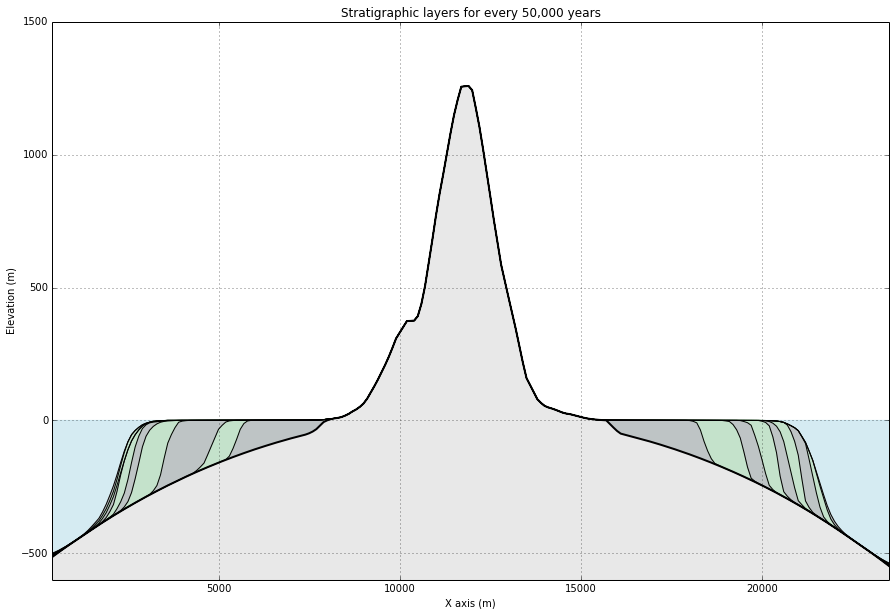

In [31]:
# Define the figure size and font
fig = plt.figure(figsize = (15,10))
plt.rc("font", size=10)

# Fill the space between the top surface and the sea-level in blue
plt.fill_between(xi00, stratiElev[yID,:,0], sl, where=sl > stratiElev[yID,:,0], color='lightblue', alpha='0.5')


# Loop through the 500 layers and plot only every 50 layers
layID = []
p = 0
for i in range(0,layTH.shape[1]-1,50):
    layID.append(i)
    if i>0:
        plt.plot(xi00,stratiElev[yID,:,i],'-',color='k',linewidth=1)
        
    if len(layID) > 1:
        # For every even number plot the sedimentary stack in grey
        if len(layID)%2 == 0:
            plt.fill_between(xi00, stratiElev[yID,:,layID[p-1]], stratiElev[yID,:,layID[p]], color='grey', alpha='0.5')
        # For every odd number plot the sedimentary stack in green
        else:
            plt.fill_between(xi00, stratiElev[yID,:,layID[p-1]], stratiElev[yID,:,layID[p]], color='palegreen', alpha='0.5')
    p = p+1

# Plot the bottom layer
plt.plot(xi00,stratiElev[yID,:,0],'-',color='k',linewidth=2)

# Fill the space between the bottom sedimentary layer and the base of the model in grey
plt.fill_between(xi00, base, stratiElev[yID,:,layID[p-1]], color='lightgrey', alpha='0.5')

# Define extent, axes and legend
plt.xlim( minX+600, maxX-700 )
plt.ylim( -600, 1500 )
plt.grid(True)
plt.title('Stratigraphic layers for every 50,000 years',fontsize=12)
plt.xlabel('X axis (m)',fontsize=10)
plt.ylabel('Elevation (m)',fontsize=10)